In [49]:
from attomics import *

from matplotlib.font_manager import FontProperties


In [2]:
# Device
device= torch.device("cuda:1")

# Import data
df_mRNA = pd.read_parquet("data_attomics/mRNA.parquet")
df_label = pd.read_parquet("data_attomics/label.parquet")

y_tumour = df_label.iloc[:, [0, 2]]

# Pick X_train
scaler=StandardScaler()
X_orignal = df_mRNA.iloc[:,1:df_mRNA.shape[1]]
X_scaled = scaler.fit_transform(X_orignal)

# Pick y_train
y_labels = set(y_tumour['cancer_type'])
y_dic = {label: index for index, label in enumerate(sorted(y_labels))}
y_numerical = np.array([y_dic[label] for label in y_tumour['cancer_type']])

In [16]:
X_train,X_testval,y_train,y_testval=train_test_split(X_scaled, y_numerical, 
                                                         test_size=0.3,random_state=2, stratify=y_numerical)

X_val,X_test,y_val,y_test=train_test_split(X_testval, y_testval, 
                                                         test_size=0.5,random_state=2, stratify=y_testval)

#Create val loader
X_val_tensor = torch.tensor(X_val,dtype=torch.float32)
y_val_tensor= torch.tensor(y_val)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(dataset= val_dataset, batch_size=64, shuffle=True)

#Create test loader
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset= test_dataset, batch_size=64, shuffle=True)

In [4]:
# Initialize logger
attomics_logger = init_logger(f"./log/Linformer{time.strftime("%d-%m-%Y %H:%M:%S",time.localtime())}.log", "Linformer")

# Create weight loss function
unique, counts = np.unique(y_numerical, return_counts=True)
total_count = sum(counts)
weights = torch.tensor([total_count / c for c in counts], dtype=torch.float32).to(device)
loss_function_weight = nn.CrossEntropyLoss(weight=weights)

# Create recorders
Errorrate_Recorder = pd.DataFrame(columns=['percent_sampling', 'error_rate', 'label', 'n_group','K_value','Out_of_memory'])
Memory_Recorder = pd.DataFrame(columns=['percent_sampling', 'memory_allocated', 'label', 'n_group','K_value','Out_of_memory'])
Time_Recorder = pd.DataFrame(columns=['percent_sampling','time', 'label', 'n_group','K_value','Out_of_memory'])

TrainLoss_Recorder = pd.DataFrame(columns=['percent_sampling','epoch', 'iteration', 'last_train_loss', 'label'])
ValLoss_Recorder = pd.DataFrame(columns=['percent_sampling','epoch', 'iteration', 'last_val_loss', 'label'])

Recorders = {'ErrorRate':Errorrate_Recorder,
             'TrainLoss':TrainLoss_Recorder,
             'ValLoss':ValLoss_Recorder,
             'Memory':Memory_Recorder,
             'Time':Time_Recorder, }

# Create reduce list
trainset_size=[0.1,0.28,0.48,0.67,0.94]

# Create hyperparameters
early_stopping=True
iteration = 5
num_epoch = 100
learning_rate = 0.0001

[2024-05-15 13:23:00,342] Linformer {attomics.py:55} INFO - ### Init. Logger Linformer ###


In [60]:
for x in [0.1,0.28,0.48,0.67,0.94]:
    print(len(X_train)*x)

654.4000000000001
1832.3200000000002
3141.12
4384.4800000000005
6151.36


### Group Accuracy test


In [5]:
n_groups=[500]
K=[5]

for k in K:
    for n_group in n_groups:
        for size in trainset_size:
            Linformer = model_bloc(f"Linformer_k_{k}", loss_function_weight)

            Recorders = Linformer(Recorders, size, X_train, y_train, val_loader, test_loader, 
                                  attomics_logger, num_classes=len(unique) ,early_stopping=early_stopping,
                                  iteration=iteration, num_epoch=num_epoch, learning_rate=learning_rate, 
                                  n_group = n_group, opt="Adam", pe=False, mem_efficient = False, 
                                  K_linformer= k)

[2024-05-15 13:23:03,617] Linformer {attomics.py:745} INFO - Linformer_k_5, reduction: 0.1, n_groups: 500, k: 5

[2024-05-15 13:23:04,142] Linformer {attomics.py:97} INFO - Number of samples: 655
Epoch 100, Loss: 0.03188371658325195
[2024-05-15 13:27:35,568] Linformer {attomics.py:843} INFO - Iteration: 1, Error rate: 0.07840342124019961

[2024-05-15 13:27:36,106] Linformer {attomics.py:97} INFO - Number of samples: 655
Epoch 100, Loss: 0.030744211748242378
[2024-05-15 13:32:00,002] Linformer {attomics.py:843} INFO - Iteration: 2, Error rate: 0.07412687099073412

[2024-05-15 13:32:00,548] Linformer {attomics.py:97} INFO - Number of samples: 655
Epoch 100, Loss: 0.031400248408317566
[2024-05-15 13:36:38,407] Linformer {attomics.py:843} INFO - Iteration: 3, Error rate: 0.07982893799002133

[2024-05-15 13:36:38,986] Linformer {attomics.py:97} INFO - Number of samples: 655
Epoch 100, Loss: 0.03183102607727051
[2024-05-15 13:41:25,649] Linformer {attomics.py:843} INFO - Iteration: 4, Error 

In [6]:
n_groups=[20]

for n_group in n_groups:
    for size in trainset_size:
        Attomics = model_bloc(f"Attomics_me", loss_function_weight)

        Recorders = Attomics(Recorders, size, X_train, y_train, val_loader, test_loader, 
                              attomics_logger, num_classes=len(unique) ,early_stopping=early_stopping,
                              iteration=iteration, num_epoch=num_epoch, learning_rate=learning_rate, 
                              n_group = n_group, opt="Adam", pe=False, mem_efficient = True, K_linformer= 0)

[2024-05-15 17:41:24,407] Linformer {attomics.py:745} INFO - Attomics_me, reduction: 0.1, n_groups: 20, k: 0

[2024-05-15 17:41:24,944] Linformer {attomics.py:97} INFO - Number of samples: 655
Epoch 100, Loss: 0.5663753747940063
[2024-05-15 17:45:25,067] Linformer {attomics.py:843} INFO - Iteration: 2, Error rate: 0.08339272986457591

[2024-05-15 17:45:25,632] Linformer {attomics.py:97} INFO - Number of samples: 655
Epoch 100, Loss: 0.6110266447067261
[2024-05-15 17:47:26,941] Linformer {attomics.py:843} INFO - Iteration: 3, Error rate: 0.09693513898788308

[2024-05-15 17:47:27,484] Linformer {attomics.py:97} INFO - Number of samples: 655
Epoch 100, Loss: 0.5727712512016296
[2024-05-15 17:49:27,627] Linformer {attomics.py:843} INFO - Iteration: 4, Error rate: 0.08624376336421957

[2024-05-15 17:49:28,170] Linformer {attomics.py:97} INFO - Number of samples: 655
Epoch 100, Loss: 0.6126312017440796
[2024-05-15 17:51:28,104] Linformer {attomics.py:843} INFO - Iteration: 5, Error rate: 0.0

### Accuracy/Time/CUDA Memory Test, fixed K-value:

In [29]:
Error_groups = Errorrate_Recorder[Errorrate_Recorder['label'] != "Linformer_k"]
Error_groups["percent_sampling"]=(Error_groups["percent_sampling"]*len(X_train)).astype(int)

Memory_groups = Memory_Recorder[Memory_Recorder['label'] != "Linformer_k"]
Memory_groups["percent_sampling"]=(Memory_groups["percent_sampling"]*len(X_train)).astype(int)

Time_groups = Time_Recorder[Time_Recorder['label'] != "Linformer_k"]
Time_groups["percent_sampling"]=(Time_groups["percent_sampling"]*len(X_train)).astype(int)

Error_groups_false, Error_groups_true = separate_df(Error_groups)
Memory_groups_false, Memory_groups_true = separate_df(Memory_groups)
Time_groups_false, Time_groups_true = separate_df(Time_groups)



In [43]:
def to_k_units(x):
    return f"{math.floor(x / 100) / 10:.1f}K"

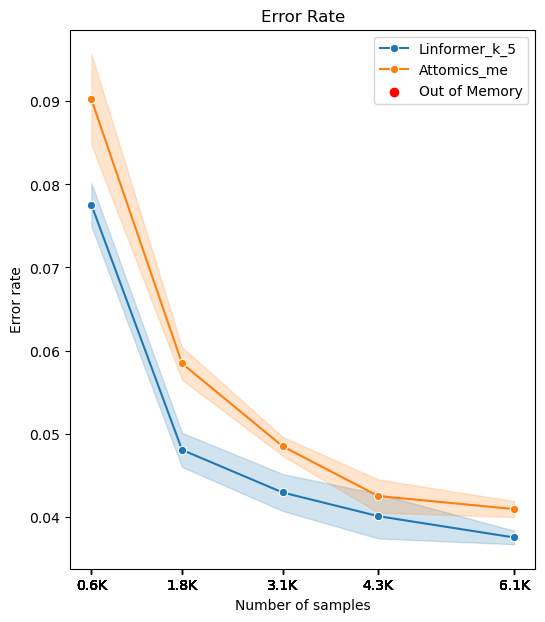

In [58]:
plt.figure(figsize=(6, 7))

ax = sns.lineplot(data=Error_groups_false, x="percent_sampling", y="error_rate",
                  marker='o', hue='label', errorbar="sd")

plt.scatter(data=Error_groups_true, x="n_group", y="y", color='red', label='Out of Memory')

for i, point in Error_groups_true.iterrows():
    label_with_newline = point['label'].replace("+", "\n")
    ax.text(point['n_group'], point['y'], label_with_newline, horizontalalignment='center', size='small', color='black')

xticks = Error_groups_false['percent_sampling']
xtick_labels = [to_k_units(x) for x in xticks]

plt.xticks(ticks=xticks, labels=xtick_labels)
    
plt.xlabel("Number of samples")
plt.ylabel("Error rate")
plt.title("Error Rate")
plt.legend()
plt.show()

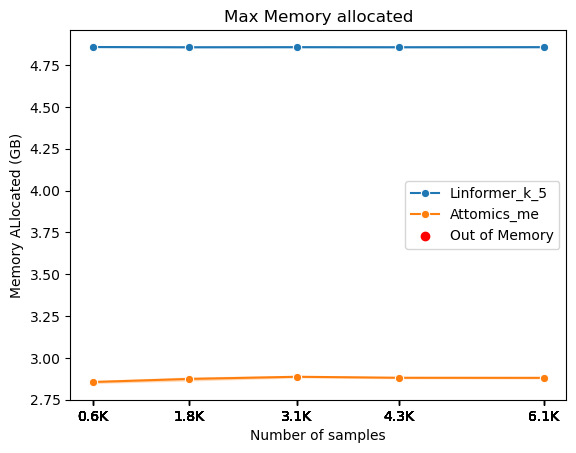

In [56]:
ax = sns.lineplot(data=Memory_groups_false, x="percent_sampling", y="memory_allocated",
                  marker='o', hue='label', errorbar="sd")

plt.scatter(data=Memory_groups_true, x="n_group", y="y", color='red', label='Out of Memory')

for i, point in Memory_groups_true.iterrows():
    label_with_newline = point['label'].replace("+", "\n")
    ax.text(point['n_group'], point['y']+ 0.02, label_with_newline, horizontalalignment='center', size='small', color='black')
    
xticks = Memory_groups_false['percent_sampling']
xtick_labels = [to_k_units(x) for x in xticks]

plt.xticks(ticks=xticks, labels=xtick_labels)

plt.title("Max Memory allocated")
plt.xlabel("Number of samples")
plt.ylabel("Memory ALlocated (GB)")
plt.legend()
plt.show()

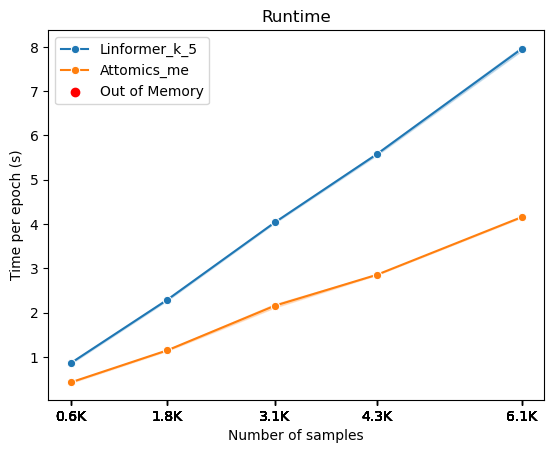

In [57]:
ax = sns.lineplot(data=Time_groups_false, x="percent_sampling", y="time",
                  marker='o', hue='label', errorbar="sd")

plt.scatter(data=Time_groups_true, x="n_group", y="y", color='red', label='Out of Memory')

for i, point in Time_groups_true.iterrows():
    label_with_newline = point['label'].replace("+", "\n")
    ax.text(point['n_group'], point['y']+ 0.02, label_with_newline, horizontalalignment='center', size='small', color='black')

xticks = Time_groups_false['percent_sampling']
xtick_labels = [to_k_units(x) for x in xticks]

plt.xticks(ticks=xticks, labels=xtick_labels)

    
plt.title("Runtime")
plt.xlabel("Number of samples")
plt.ylabel("Time per epoch (s)")
plt.legend()
plt.show()

### Loss

Text(0.5, 1.0, 'Training Loss for Linformer Model')

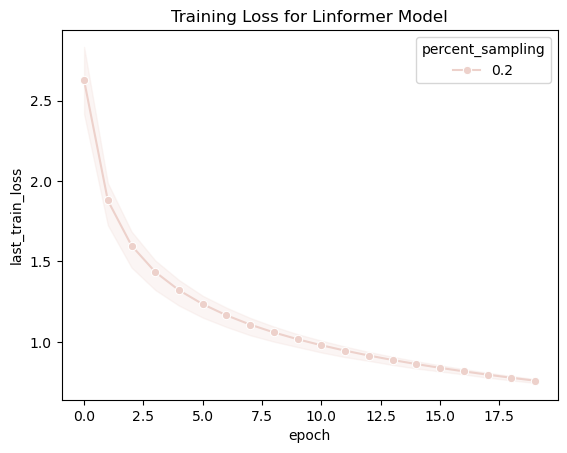

In [8]:
#'percent_sampling', 'epoch', 'iteration', 'last_train_loss', 'label'
sns.lineplot(data=TrainLoss_Recorder[TrainLoss_Recorder['label'] == 'Linformer'], 
             x="epoch", y="last_train_loss",  marker='o', hue='percent_sampling')

plt.title("Training Loss for Linformer Model")

Text(0.5, 1.0, 'Training Loss for Linformer Model')

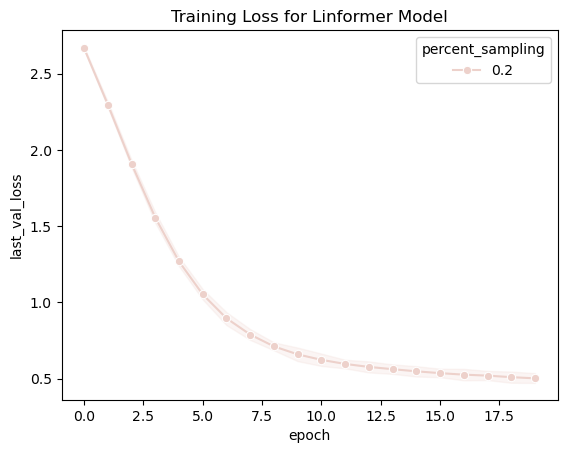

In [11]:
#'percent_sampling', 'epoch', 'iteration', 'last_train_loss', 'label'
sns.lineplot(data=ValLoss_Recorder[ValLoss_Recorder['label'] == 'Linformer_2500_Groups'], 
             x="epoch", y="last_val_loss",  marker='o', hue='percent_sampling')

plt.title("Training Loss for Linformer Model")